In [68]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

from scipy.stats import skew

import warnings

warnings.filterwarnings('ignore')

In [46]:
def preprocessing(train_url, test_url, test_y_url):

    df_train = pd.read_csv(train_url)
    df_train['Garage_Yr_Blt'] = df_train['Garage_Yr_Blt'].fillna(0)
    y = np.log(df_train['Sale_Price'])
    df_train = df_train.drop(['PID','Sale_Price'],axis = 1)

    features_to_remove = ['Street', 'Utilities', 'Condition_2', 'Roof_Matl', 'Heating', 'Pool_QC', 'Misc_Feature', 'Low_Qual_Fin_SF', 'Pool_Area', 'Longitude','Latitude']
    df_train = df_train.drop(features_to_remove,axis = 1)

    features_to_winsor = ["Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "BsmtFin_SF_2", "Bsmt_Unf_SF", "Total_Bsmt_SF", "Second_Flr_SF", 'First_Flr_SF', "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF", "Enclosed_Porch", "Three_season_porch", "Screen_Porch", "Misc_Val"]

    def revalue_column(x, M):
        if x < M:
            return x
        else:
            return M

    percentile = 0.95
    Winzorization_M = []
    for column in features_to_winsor:
        M = df_train[column].quantile(percentile)
        df_train[column] = df_train[column].apply(lambda x: revalue_column(x, M))
        Winzorization_M.append(M)

    categorical_features = df_train.select_dtypes(include=['object', 'category'])
    numerical_features = df_train.select_dtypes(exclude=['object', 'category'])

    scaler = StandardScaler()
    scaled_numerical_features = scaler.fit_transform(numerical_features)
    scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_features.columns)

    encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
    encoded_categorical_features = encoder.fit_transform(categorical_features)
    encoded_categorical_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))

    df_encoded = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)



    df_test = pd.read_csv(test_url)
    y_test = pd.read_csv(test_y_url)
    y_test_log = np.log(y_test['Sale_Price'])

    df_test['Garage_Yr_Blt'] = df_test['Garage_Yr_Blt'].fillna(0)
    df_test = df_test.drop(['PID'],axis = 1)
    df_test = df_test.drop(features_to_remove,axis = 1)
    for column, M in zip(features_to_winsor,Winzorization_M):
        df_test[column] = df_test[column].apply(lambda x: revalue_column(x, M))

    categorical_features_test = df_test.select_dtypes(include=['object', 'category'])
    numerical_features_test = df_test.select_dtypes(exclude=['object', 'category'])
    scaled_numerical_features_test = scaler.transform(numerical_features_test)
    scaled_numerical_df_test = pd.DataFrame(scaled_numerical_features_test, columns=numerical_features.columns)
    encoded_categorical_features_test = encoder.transform(categorical_features_test)
    encoded_categorical_df_test = pd.DataFrame(encoded_categorical_features_test, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))
    df_encoded_test = pd.concat([scaled_numerical_df_test, encoded_categorical_df_test], axis=1)

    return df_encoded, y, df_encoded_test, y_test_log

In [125]:
def preprocessing2(train_url, test_url, test_y_url):

    df_train = pd.read_csv(train_url)
    df_train['Garage_Yr_Blt'] = df_train['Garage_Yr_Blt'].fillna(0)
    y = np.log(df_train['Sale_Price'])
    df_train = df_train.drop(['PID','Sale_Price'],axis = 1)

    
    imbalance_threshold = 0.95  # For example, 95% of the samples belonging to one category
    imbalanced_columns = []
    for column in df_train.columns:
        value_counts = df_train[column].value_counts(normalize=True)
        most_common_category = value_counts.idxmax()
        most_common_category_percentage = value_counts.max()    
    if most_common_category_percentage >= imbalance_threshold:
        imbalanced_columns.append(column)
    df_train = df_train.drop(imbalanced_columns,axis = 1)

    numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
#     skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#     skewed_feats = skewed_feats[skewed_feats > 0.75]
#     skewed_feats = skewed_feats.index
#     df_train[skewed_feats] = np.log1p(df_train[skewed_feats])

#    features_to_winsor = ["Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "BsmtFin_SF_2", "Bsmt_Unf_SF", "Total_Bsmt_SF", "Second_Flr_SF", 'First_Flr_SF', "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF", "Enclosed_Porch", "Three_season_porch", "Screen_Porch", "Misc_Val"]
    features_to_winsor = numeric_feats
    def revalue_column(x, M):
        if x < M:
            return x
        else:
            return M

    percentile = 0.95
    Winzorization_M = []
    for column in features_to_winsor:
        M = df_train[column].quantile(percentile)
        df_train[column] = df_train[column].apply(lambda x: revalue_column(x, M))
        Winzorization_M.append(M)
        
#     skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#     skewed_feats = skewed_feats[skewed_feats > 0.75]
#     skewed_feats = skewed_feats.index
#     df_train[skewed_feats] = np.log1p(df_train[skewed_feats])
    

    categorical_features = df_train.select_dtypes(include=['object', 'category'])
    numerical_features = df_train.select_dtypes(exclude=['object', 'category'])

    scaler = StandardScaler()
    scaled_numerical_features = scaler.fit_transform(numerical_features)
    scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_features.columns)

    encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
    encoded_categorical_features = encoder.fit_transform(categorical_features)
    encoded_categorical_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))

    df_encoded = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)



    df_test = pd.read_csv(test_url)
    y_test = pd.read_csv(test_y_url)
    y_test_log = np.log(y_test['Sale_Price'])

    df_test['Garage_Yr_Blt'] = df_test['Garage_Yr_Blt'].fillna(0)
    df_test = df_test.drop(['PID'],axis = 1)
    df_test = df_test.drop(imbalanced_columns,axis = 1)
#    df_test[skewed_feats] = np.log1p(df_test[skewed_feats])
    for column, M in zip(features_to_winsor, Winzorization_M):
        df_test[column] = df_test[column].apply(lambda x: revalue_column(x, M))
#    df_test[skewed_feats] = np.log1p(df_test[skewed_feats])

    categorical_features_test = df_test.select_dtypes(include=['object', 'category'])
    numerical_features_test = df_test.select_dtypes(exclude=['object', 'category'])
    scaled_numerical_features_test = scaler.transform(numerical_features_test)
    scaled_numerical_df_test = pd.DataFrame(scaled_numerical_features_test, columns=numerical_features.columns)
    encoded_categorical_features_test = encoder.transform(categorical_features_test)
    encoded_categorical_df_test = pd.DataFrame(encoded_categorical_features_test, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))
    df_encoded_test = pd.concat([scaled_numerical_df_test, encoded_categorical_df_test], axis=1)

    return df_encoded, y, df_encoded_test, y_test_log

In [136]:
def rmse(y, y_pred):
    n = len(y)
    return np.sqrt(sum((y-y_pred)**2) / n)


def model_fit(model, df_encoded, y, df_encoded_test, y_test_log, random_state = 0):

    if model == 'elastic_net':
        elastic_net = ElasticNet(l1_ratio = 0.5)
        alphas = np.logspace(-4, 3, 15)
        param_grid = {'alpha': alphas}
        kfold = KFold(n_splits=5, shuffle=True, random_state=0)  # Example 5-fold cross-validation

        grid_search = GridSearchCV(elastic_net, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(df_encoded, y)

        best_alpha = grid_search.best_params_['alpha']
        best_elastic_net = ElasticNet(alpha=best_alpha, l1_ratio = 0.5, random_state = random_state)
        best_elastic_net.fit(df_encoded, y)

        y_pred = best_elastic_net.predict(df_encoded_test)
        
        return rmse(y_pred, y_test_log)

    

    
    if model == 'xgboost':
        xgb_model = XGBRegressor(n_estimators=5000, learning_rate=0.05, max_depth=6, subsample = 0.5, random_state=random_state)
        xgb_model.fit(df_encoded, y)
        y_pred = xgb_model.predict(df_encoded_test)

        return rmse(y_pred, y_test_log)

In [112]:
folder_path = 'proj1/fold'+str(1) + '/'
train_url =folder_path +'train.csv'
test_url = folder_path+'test.csv'
test_y_url = folder_path+'test_y.csv'

In [113]:
df_encoded, y, df_encoded_test, y_test_log  = preprocessing2(train_url, test_url, test_y_url)

In [139]:
elastic_net = ElasticNet(l1_ratio = 0.5)
alphas = np.logspace(-4, 3, 15)
param_grid = {'alpha': alphas}
kfold = KFold(n_splits=5, shuffle=True, random_state=0)  # Example 5-fold cross-validation

grid_search = GridSearchCV(elastic_net, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(df_encoded, y)

best_alpha = grid_search.best_params_['alpha']
best_elastic_net = ElasticNet(alpha=best_alpha, l1_ratio = 0.5, random_state = 0)
best_elastic_net.fit(df_encoded, y)

y_pred = best_elastic_net.predict(df_encoded_test)

In [142]:
df_test = pd.read_csv(test_url)

In [145]:
df_PID = df_test[['PID']]

In [147]:
df_PID['Sale_Price'] = y_pred

In [150]:
df_PID.to_csv('data.txt', index=False)

In [114]:
model_fit('elastic_net', df_encoded, y, df_encoded_test, y_test_log)

0.120418471337646

In [115]:
model_fit('xgboost', df_encoded, y, df_encoded_test, y_test_log)

0.11732956032094531

In [137]:
import time
eln_rmses = []
xgb_rmses = []
start = time.time()
for i in range(1, 11):
    folder_path = 'proj1/fold' + str(i) + '/'
    train_url = folder_path +'train.csv'
    test_url = folder_path +'test.csv'
    test_y_url = folder_path+'test_y.csv'
    df_encoded, y, df_encoded_test, y_test_log  = preprocessing2(train_url, test_url, test_y_url)
    eln_rmse = model_fit('elastic_net', df_encoded, y, df_encoded_test, y_test_log)
    xgb_rmse = model_fit('xgboost', df_encoded, y, df_encoded_test, y_test_log)
    eln_rmses.append(eln_rmse)
    xgb_rmses.append(xgb_rmse)
    print('fold%i is processed'%i)
    print('eln_rmse: %0.4f; xgb_rmse: %0.4f'%(eln_rmse,xgb_rmse))
    end = time.time()
    print('time eclapsed: %0.2f seconds'%(end - start))

fold1 is processed
eln_rmse: 0.1204; xgb_rmse: 0.1173
time eclapsed: 11.90 seconds
fold2 is processed
eln_rmse: 0.1167; xgb_rmse: 0.1202
time eclapsed: 24.47 seconds
fold3 is processed
eln_rmse: 0.1169; xgb_rmse: 0.1121
time eclapsed: 36.38 seconds
fold4 is processed
eln_rmse: 0.1190; xgb_rmse: 0.1187
time eclapsed: 48.32 seconds
fold5 is processed
eln_rmse: 0.1100; xgb_rmse: 0.1082
time eclapsed: 59.26 seconds
fold6 is processed
eln_rmse: 0.1344; xgb_rmse: 0.1263
time eclapsed: 71.80 seconds
fold7 is processed
eln_rmse: 0.1346; xgb_rmse: 0.1337
time eclapsed: 84.40 seconds
fold8 is processed
eln_rmse: 0.1317; xgb_rmse: 0.1258
time eclapsed: 96.08 seconds
fold9 is processed
eln_rmse: 0.1342; xgb_rmse: 0.1342
time eclapsed: 107.70 seconds
fold10 is processed
eln_rmse: 0.1257; xgb_rmse: 0.1172
time eclapsed: 122.14 seconds


In [133]:
eln_rmses

[0.12072248178924753,
 0.11633318961225038,
 0.11255926425295261,
 0.11743469806470508,
 0.10960988690287644,
 0.13491271115423845,
 0.13293956054909162,
 0.13389810631405274,
 0.13188625697097178,
 0.12386253372623444]

In [130]:
eln_rmses

[0.120418471337646,
 0.11666886892240716,
 0.11692502547780458,
 0.11898300292600848,
 0.10998529498473042,
 0.13443988501751325,
 0.13458532311350888,
 0.13167427127322787,
 0.1341872395086161,
 0.12570331901397372]

In [128]:
eln_rmses

[0.12069066581966756,
 0.11902959662452446,
 0.11502475387016499,
 0.11697840041219981,
 0.1088991384088278,
 0.1351791936474391,
 0.1344472506779932,
 0.13033436174513743,
 0.13417875497262374,
 0.12368109290158238]

In [123]:
eln_rmses

[0.1211615943289207,
 0.1209208942003242,
 0.11153898855056284,
 0.1158000473091199,
 0.10900082225430156,
 0.1357887975112798,
 0.13191338841275926,
 0.1263647849793146,
 0.13105938373445072,
 0.12392414411441534]

/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+00, tolerance: 2.864e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.148e-01, tolerance: 2.847e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.464e-01, tolerance: 2.712e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e+00, tolerance: 2.686e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

In [121]:
eln_rmses

[0.12072248178924753,
 0.11633318961225038,
 0.11255926425295261,
 0.11743469806470508,
 0.10960988690287644,
 0.13491271115423845,
 0.13293956054909162,
 0.13389810631405274,
 0.13188625697097178,
 0.12386253372623444]

In [117]:
eln_rmses

[0.120418471337646,
 0.11666886892240716,
 0.11692502547780458,
 0.11898300292600848,
 0.10998529498473042,
 0.13443988501751325,
 0.13458532311350888,
 0.13167427127322787,
 0.1341872395086161,
 0.12570331901397372]

In [97]:
eln_rmses

[0.12117906825137706,
 0.11806604146802802,
 0.11255926425295261,
 0.11743469806470508,
 0.11107018559263114,
 0.13431090809867519,
 0.13271771215242636,
 0.12686393231411497,
 0.13188625697097178,
 0.12386253372623444]

In [108]:
eln_rmses

[0.12111503755535953,
 0.11780625016047122,
 0.11288599993081909,
 0.11912189231238829,
 0.1114042935701811,
 0.13447403936311234,
 0.13230734164845728,
 0.12712197432196867,
 0.13170810230854502,
 0.12418013178693559]

In [63]:
xgb_rmses

[0.11521064825100598,
 0.12083709578120248,
 0.1114245994361075,
 0.11753014559583687,
 0.10920187545843645,
 0.128620731930087,
 0.13382469074812803,
 0.12404221889504212,
 0.13139080806414577,
 0.11799568097986832]

In [98]:
xgb_rmses

[0.11732956032094531,
 0.12016572767739202,
 0.11212499820355673,
 0.1186715010588801,
 0.10820671969446001,
 0.1262689839057414,
 0.13374288384177183,
 0.1258002162404412,
 0.134228976749172,
 0.11723192465346849]

In [109]:
xgb_rmses

[0.11732956032094531,
 0.12016572767739202,
 0.11212499820355673,
 0.1186715010588801,
 0.10820671969446001,
 0.1262689839057414,
 0.13374288384177183,
 0.1258002162404412,
 0.134228976749172,
 0.11723192465346849]

/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.685e-02, tolerance: 2.745e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.302e-02, tolerance: 2.712e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e-02, tolerance: 2.864e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.387e-02, tolerance: 2.782e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wenbofu/miniforge3/envs/torch_m1/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

In [97]:
df_train = pd.read_csv('train.csv')
y= np.log(df_train['Sale_Price'])

In [98]:
df_train.columns[df_train.isnull().any()]

Index(['Garage_Yr_Blt'], dtype='object')

In [99]:
df_train['Garage_Yr_Blt'] = df_train['Garage_Yr_Blt'].fillna(0)

In [100]:
y = np.log(df_train['Sale_Price'])

In [101]:
df_train = df_train.drop(['PID','Sale_Price'],axis = 1)

In [102]:
features_to_remove = ['Street', 'Utilities', 'Condition_2', 'Roof_Matl', 'Heating', 'Pool_QC', 'Misc_Feature', 'Low_Qual_Fin_SF', 'Pool_Area', 'Longitude','Latitude']

In [103]:
df_train = df_train.drop(features_to_remove,axis = 1)

In [111]:
features_to_winsor = ["Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "BsmtFin_SF_2", "Bsmt_Unf_SF", "Total_Bsmt_SF", "Second_Flr_SF", 'First_Flr_SF', "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF", "Enclosed_Porch", "Three_season_porch", "Screen_Porch", "Misc_Val"]

In [112]:
def revalue_column(x, M):
    if x < M:
        return x
    else:
        return M


percentile = 0.95
Winzorization_M = []

for column in features_to_winsor:
  M = df_train[column].quantile(percentile)
  df_train[column] = df_train[column].apply(lambda x: revalue_column(x, M))
  Winzorization_M.append(M)

In [49]:
Winzorization_M

[104.0,
 16971.5,
 472.0,
 445.0,
 1452.0,
 1756.5,
 1130.0,
 1813.5,
 2466.0,
 852.5,
 324.0,
 179.0,
 174.5,
 0.0,
 168.0,
 0.0]

In [113]:
categorical_features = df_train.select_dtypes(include=['object', 'category'])
numerical_features = df_train.select_dtypes(exclude=['object', 'category'])

In [118]:
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_features.columns)

In [119]:
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoded_categorical_features = encoder.fit_transform(categorical_features)
encoded_categorical_df = pd.DataFrame(encoded_categorical_features, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))

In [120]:
df_encoded = pd.concat([scaled_numerical_df, encoded_categorical_df], axis=1)

In [121]:
df_encoded.columns

Index(['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
       'Total_Bsmt_SF', 'First_Flr_SF',
       ...
       'Sale_Type_New', 'Sale_Type_Oth', 'Sale_Type_VWD', 'Sale_Type_WD ',
       'Sale_Condition_Abnorml', 'Sale_Condition_AdjLand',
       'Sale_Condition_Alloca', 'Sale_Condition_Family',
       'Sale_Condition_Normal', 'Sale_Condition_Partial'],
      dtype='object', length=309)

In [146]:
from sklearn.linear_model import ElasticNet

In [160]:
elastic_net = ElasticNet(alpha=0.005, l1_ratio = 0.2,random_state= 0)

In [161]:
elastic_net.fit(df_encoded,y)

ElasticNet(alpha=0.005, l1_ratio=0.2, random_state=0)

In [162]:
y_pred = elastic_net.predict(df_encoded_test)

In [163]:
rmse(y_pred, y_test_log)

0.12748864364177825

In [175]:
elastic_net = ElasticNet(l1_ratio = 0.2)
alphas = np.logspace(-4, 3, 15)

In [178]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [179]:
param_grid = {'alpha': alphas}
kfold = KFold(n_splits=5, shuffle=True, random_state=0)  # Example 5-fold cross-validation

grid_search = GridSearchCV(elastic_net, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(df_encoded, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=ElasticNet(l1_ratio=0.2), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [180]:
best_alpha = grid_search.best_params_['alpha']

In [181]:
best_alpha

0.001

In [182]:
best_elastic_net = ElasticNet(alpha=best_alpha, l1_ratio = 0.2, random_state = 0)
best_elastic_net.fit(df_encoded, y)

ElasticNet(alpha=0.001, l1_ratio=0.2, random_state=0)

In [183]:
y_pred = best_elastic_net.predict(df_encoded_test)

In [184]:
rmse(y_pred, y_test_log)

0.12116167243607291

In [141]:
from xgboost import XGBRegressor

In [142]:
xgb = XGBRegressor(n_estimators=5000, learning_rate=0.05, max_depth=6, subsample = 0.5, random_state=0)

In [143]:
xgb.fit(df_encoded, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [144]:
y_pred = xgb.predict(df_encoded_test)

In [145]:
rmse(y_pred, y_test_log)

0.11521064825100598

In [186]:
df_test = pd.read_csv('test.csv')
y_test = pd.read_csv('test_y.csv')

In [187]:
y_test_log = np.log(y_test['Sale_Price'])

In [188]:
df_test['Garage_Yr_Blt'] = df_test['Garage_Yr_Blt'].fillna(0)

In [189]:
df_test.drop(['PID'],axis = 1)

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0,8926,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,Minimum_Privacy,None,0,10,2009,COD,Abnorml,-93.663302,42.018592
1,Two_Story_1945_and_Older,Residential_Medium_Density,57,6876,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,8,2009,WD,Normal,-93.628299,42.025306
2,Two_Story_1946_and_Newer,Residential_Low_Density,0,13869,Pave,No_Alley_Access,Moderately_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,7,2007,WD,Normal,-93.636146,42.061664
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,87,10000,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,2,2010,WD,Normal,-93.605943,42.034748
4,One_and_Half_Story_Finished_All_Ages,Residential_Medium_Density,60,10320,Pave,Gravel,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2008,WD,Normal,-93.624580,42.023716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,Two_Story_1946_and_Newer,Residential_Low_Density,80,11584,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,11,2007,WD,Normal,-93.638554,42.052353
875,Two_Story_1946_and_Newer,Residential_Low_Density,72,7200,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,2,2008,WD,Normal,-93.675173,42.018912
876,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,84,11670,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,3,2007,WD,Normal,-93.642069,42.054318
877,Two_Story_PUD_1946_and_Newer,Floating_Village_Residential,30,3215,Pave,Paved,Regular,Lvl,AllPub,Inside,...,No_Pool,No_Fence,None,0,4,2010,ConLD,Normal,-93.645599,42.048566


In [129]:
df_test = df_test.drop(features_to_remove,axis = 1)

In [130]:
for column, M in zip(features_to_winsor,Winzorization_M):
  df_test[column] = df_test[column].apply(lambda x: revalue_column(x, M))

In [132]:
categorical_features_test = df_test.select_dtypes(include=['object', 'category'])
numerical_features_test = df_test.select_dtypes(exclude=['object', 'category'])

In [133]:
scaled_numerical_features_test = scaler.transform(numerical_features_test)
scaled_numerical_df_test = pd.DataFrame(scaled_numerical_features_test, columns=numerical_features.columns)

In [134]:
encoded_categorical_features_test = encoder.transform(categorical_features_test)
encoded_categorical_df_test = pd.DataFrame(encoded_categorical_features_test, columns=encoder.get_feature_names_out(input_features=categorical_features.columns))

In [138]:
df_encoded_test = pd.concat([scaled_numerical_df_test, encoded_categorical_df_test], axis=1)

In [149]:
y_pred = elastic_net.predict(df_encoded_test)

In [150]:
def rmse(y, y_pred):
  n = len(y)
  return np.sqrt(sum((y-y_pred)**2) / n)

rmse(y_pred, y_test_log)

0.35515043960755166

In [142]:
df_test_encoded = pd.get_dummies(df_test)

In [143]:
missing_columns = set(X.columns)-set(df_test_encoded.columns)

In [145]:
for column in missing_columns:
  df_test_encoded[column] = 0

In [147]:
X_test = df_test_encoded[X.columns]

In [148]:
y_pred = elastic_net.predict(X_test)

In [151]:
y_test_log = np.log(y_test['Sale_Price'])

In [159]:
y_test_log[0]

11.626254150277232

In [152]:
def rmse(y, y_pred):
  n = len(y)
  return np.sqrt(sum((y-y_pred)**2) / n)

rmse(y_pred, y_test_log)

0.16816170225577526

In [156]:
y_pred - y_test_log

0     -0.059820
1     -0.070267
2     -0.040957
3     -0.173000
4     -0.092588
         ...   
874   -0.131018
875   -0.068497
876   -0.103668
877   -0.021169
878    0.203320
Name: Sale_Price, Length: 879, dtype: float64

In [155]:
y_test_log

0      11.626254
1      11.911702
2      12.083905
3      11.982929
4      11.813030
         ...    
874    12.190959
875    11.986049
876    12.676076
877    11.951180
878    12.007622
Name: Sale_Price, Length: 879, dtype: float64

In [33]:
imbalance_threshold = 0.95  # For example, 95% of the samples belonging to one category

# Iterate through columns to check for imbalance
imbalanced_columns = []
imbalanced_columns_info = []

for column in df_train.columns:
  value_counts = df_train[column].value_counts(normalize=True)
  most_common_category = value_counts.idxmax()
  most_common_category_percentage = value_counts.max()

  if most_common_category_percentage >= imbalance_threshold:
    imbalanced_columns.append(column)
    imbalanced_columns_info.append((column, most_common_category, most_common_category_percentage))

print("Imbalanced columns:")
for col, category, percentage in imbalanced_columns_info:
  print(f"Column '{col}' has {percentage * 100:.2f}% of samples in category '{category}'")

Imbalanced columns:
Column 'Street' has 99.46% of samples in category 'Pave'
Column 'Utilities' has 99.90% of samples in category 'AllPub'
Column 'Land_Slope' has 95.08% of samples in category 'Gtl'
Column 'Condition_2' has 98.73% of samples in category 'Norm'
Column 'Roof_Matl' has 98.54% of samples in category 'CompShg'
Column 'Heating' has 98.54% of samples in category 'GasA'
Column 'Low_Qual_Fin_SF' has 98.59% of samples in category '0'
Column 'Kitchen_AbvGr' has 95.76% of samples in category '1'
Column 'Three_season_porch' has 98.78% of samples in category '0'
Column 'Pool_Area' has 99.66% of samples in category '0'
Column 'Pool_QC' has 99.66% of samples in category 'No_Pool'
Column 'Misc_Feature' has 96.29% of samples in category 'None'
Column 'Misc_Val' has 96.44% of samples in category '0'


In [34]:
df_new = df_train.drop(columns=imbalanced_columns)

In [35]:
df_new.columns

Index(['PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Alley',
       'Lot_Shape', 'Land_Contour', 'Lot_Config', 'Neighborhood',
       'Condition_1', 'Bldg_Type', 'House_Style', 'Overall_Qual',
       'Overall_Cond', 'Year_Built', 'Year_Remod_Add', 'Roof_Style',
       'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Mas_Vnr_Area',
       'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond',
       'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2',
       'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating_QC',
       'Central_Air', 'Electrical', 'First_Flr_SF', 'Second_Flr_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd',
       'Functional', 'Fireplaces', 'Fireplace_Qu', 'Garage_Type',
       'Garage_Yr_Blt', 'Garage_Finish', 'Garage_Cars', 'Garage_Area',
       'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Wood_Deck_SF',
       'Open_P

In [36]:
from scipy.stats import skew

df_new["Sale_Price"] = np.log(df_new["Sale_Price"])

#log transform skewed numeric features:
numeric_feats = df_new.dtypes[df_new.dtypes != "object"].index

skewed_feats = df_new[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df_new[skewed_feats] = np.log1p(df_new[skewed_feats])

In [37]:
df_encoded = pd.get_dummies(df_new)

In [39]:
y = df_encoded['Sale_Price']

In [40]:
X = df_encoded.drop(['Sale_Price','PID'],axis = 1)

In [41]:
train_columns = set(X.columns)

In [75]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [44]:
model_ridge = Ridge()

In [45]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

In [73]:
cv_ridge

0.05     0.139059
0.10     0.137327
0.30     0.133783
1.00     0.130003
3.00     0.127648
5.00     0.127168
10.00    0.127387
15.00    0.128076
30.00    0.130461
50.00    0.133393
75.00    0.136500
dtype: float64

Text(0, 0.5, 'rmse')

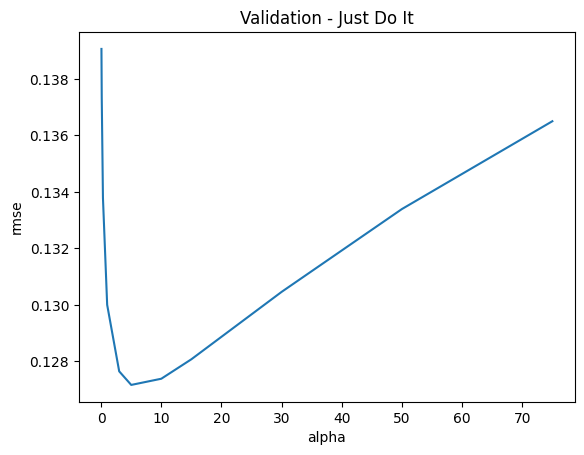

In [46]:
import matplotlib.pyplot as plt

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [47]:
cv_ridge.min()

0.12716763726093866

In [77]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)

In [79]:
y_pred = model_lasso.predict(X_test)

In [81]:
y_test_new

0      11.626254
1      11.911702
2      12.083905
3      11.982929
4      11.813030
         ...    
874    12.190959
875    11.986049
876    12.676076
877    11.951180
878    12.007622
Name: Sale_Price, Length: 879, dtype: float64

In [84]:
np.sqrt(sum((y_pred - y_test_new)**2)/len(y_pred))

0.2917366702819464

In [69]:
rmse_cv(model_lasso)

array([0.14594604, 0.11708004, 0.14004829, 0.12519862, 0.10891928])

In [51]:
df_test.columns[df_test.isnull().any()]

Index(['Garage_Yr_Blt'], dtype='object')

In [53]:
df_test['Garage_Yr_Blt'] = df_test['Garage_Yr_Blt'].fillna(0)

In [54]:
df_test = df_test.drop(columns=imbalanced_columns)

In [55]:
df_test[skewed_feats] = np.log1p(df_test[skewed_feats])

In [56]:
df_test_encoded = pd.get_dummies(df_test)

In [57]:
X_test = df_test.drop(['PID'],axis = 1)

In [58]:
test_columns = set(X_test.columns)

In [61]:
len(test_columns)

68

In [62]:
len(df_train.columns)

83

In [63]:
len(df_test.columns)

69

In [64]:
missing_columns = train_columns - test_columns

In [66]:
for column in missing_columns:
    X_test[column] = 0

<ipython-input-66-8eab85f2b3ab>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
<ipython-input-66-8eab85f2b3ab>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
<ipython-input-66-8eab85f2b3ab>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
<

In [67]:
X_test = X_test[X.columns]

In [72]:
y_test_new = np.log(y_test['Sale_Price'])

In [71]:
y_test_new

0      112000
1      149000
2      177000
3      160000
4      135000
        ...  
874    197000
875    160500
876    320000
877    155000
878    164000
Name: Sale_Price, Length: 879, dtype: int64